In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
match_info = pd.read_csv("../data/match_info.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
train.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,33.485444,31.322445,38.274752,True,126283_1
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,38.100808,37.371285,30.632980,True,126283_1
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,30.632980,38.391570,24.613144,True,126283_1
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,24.613144,34.573350,5.545468,True,126283_1
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,6.058256,21.274470,18.437112,True,126283_1


In [46]:
train[['start_x', 'start_y', 'end_x', 'end_y']].describe()

,start_x,start_y,end_x,end_y
count,356721.000000,356721.000000,356721.000000,356721.000000
mean,47.259486,34.150991,51.038351,34.127722
std,23.813701,19.800665,24.291506,19.718240
min,0.000000,0.000000,0.000000,0.000000
25%,29.758365,17.105876,33.516630,16.964164
50%,46.978890,34.265880,50.349495,34.264724
75%,64.429260,51.243304,68.994765,51.257244
max,105.000000,68.000000,105.000000,68.000000


In [44]:
train[train['is_home']==True]['end_x']

0         31.322445
1         37.371285
2         38.391570
3         34.573350
4         21.274470
            ...    
356712    51.340170
356713    58.873815
356714    67.206300
356719    63.547890
356720    72.663360
Name: end_x, Length: 179385, dtype: float64

In [45]:
train[train['is_home']==False]['end_x']

16        37.866780
17        51.285465
30        20.074215
31        19.823370
32        15.231090
            ...    
356708    68.723865
356715    62.394465
356716    62.394465
356717    76.747020
356718    86.547720
Name: end_x, Length: 177336, dtype: float64

In [4]:
train['type_name'].value_counts()

type_name
Pass                178582
Carry                82046
Recovery             27352
Interception         11088
Duel                  8734
Tackle                8138
Throw-In              6801
Clearance             6563
Intervention          6038
Block                 3983
Pass_Freekick         3824
Cross                 3589
Goal Kick             2713
Error                 1647
Shot                  1413
Pass_Corner           1137
Catch                 1019
Take-On                987
Aerial Clearance       478
Parry                  373
Hit                    130
Shot_Freekick           43
Foul                    26
Deflection              14
Penalty Kick             2
Handball_Foul            1
Name: count, dtype: int64

In [5]:
train[train.isna().any(axis=1)]['type_name'].value_counts()

type_name
Carry            82046
Recovery         27352
Interception     11088
Clearance         6563
Intervention      6038
Block             3983
Error             1647
Catch             1019
Parry              373
Hit                130
Deflection          14
Handball_Foul        1
Name: count, dtype: int64

In [6]:
train['player_id'].value_counts()

player_id
500115    3668
500569    3667
250101    3561
345446    3322
500140    3060
          ... 
247324       2
367697       2
500551       2
491805       2
491841       1
Name: count, Length: 446, dtype: int64

In [7]:
train[train['type_name'] == 'Pass']['player_id'].value_counts()

player_id
500569    1913
500115    1846
250101    1844
345446    1790
491810    1714
          ... 
357155       1
247324       1
500551       1
491841       1
491805       1
Name: count, Length: 446, dtype: int64

In [8]:
# 1. 'Pass' 이벤트인 player_id의 빈도수 계산
pass_counts = train[train['type_name'] == 'Pass']['player_id'].value_counts()

# 2. 빈도수가 1000 이상인 데이터만 남기기 (Boolean Indexing)
pass_counts_over_1000 = pass_counts[pass_counts >= 1000]

pass_counts_over_1000

player_id
500569    1913
500115    1846
250101    1844
345446    1790
491810    1714
354812    1709
344467    1657
500452    1581
500140    1502
187316    1487
500576    1460
500126    1446
408792    1399
250055    1380
250036    1345
145673    1345
77828     1337
287282    1329
500527    1303
61979     1296
500520    1268
61981     1266
77845     1265
500145    1254
500602    1244
187259    1227
62365     1213
344558    1210
500549    1195
246402    1175
62086     1167
145831    1159
161110    1154
150850    1153
145703    1141
503173    1132
356596    1130
357146    1121
407441    1119
77579     1102
287281    1100
500533    1056
356604    1054
250076    1044
500138    1033
500129    1020
500534    1017
500430    1011
Name: count, dtype: int64

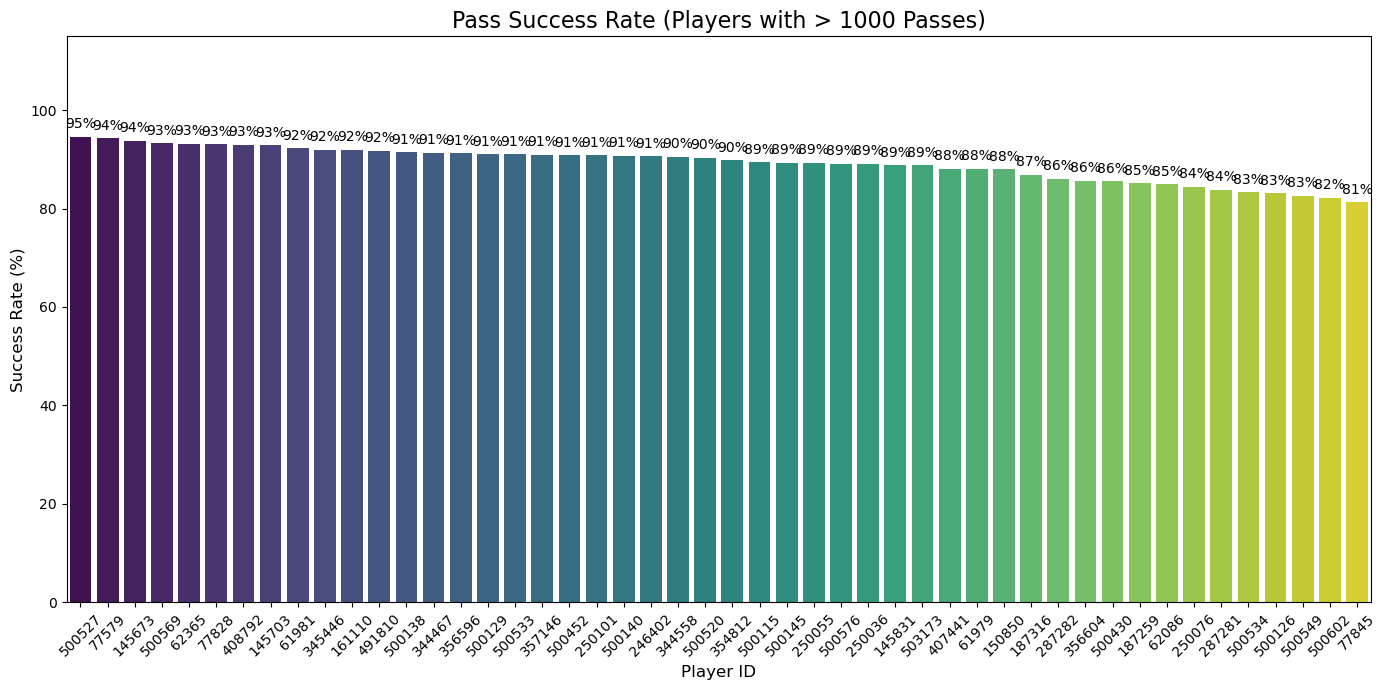

In [9]:
target_player_ids = pass_counts_over_1000.index

# 2. 전체 데이터에서 해당 선수들의 'Pass' 이벤트만 필터링
filtered_pass_data = train[
    (train['type_name'] == 'Pass') & 
    (train['player_id'].isin(target_player_ids))
].copy()

filtered_pass_data['is_successful'] = (filtered_pass_data['result_name'] == 'Successful').astype(int)
success_rates = filtered_pass_data.groupby('player_id')['is_successful'].mean() * 100
success_rates = success_rates.reset_index(name='success_rate')

success_rates = success_rates.sort_values(by='success_rate', ascending=False)

# 5. 시각화
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='player_id', y='success_rate', data=success_rates, 
                 order=success_rates['player_id'], palette='viridis')

plt.title('Pass Success Rate (Players with > 1000 Passes)', fontsize=16)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.xlabel('Player ID', fontsize=12)
plt.ylim(0, 115)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

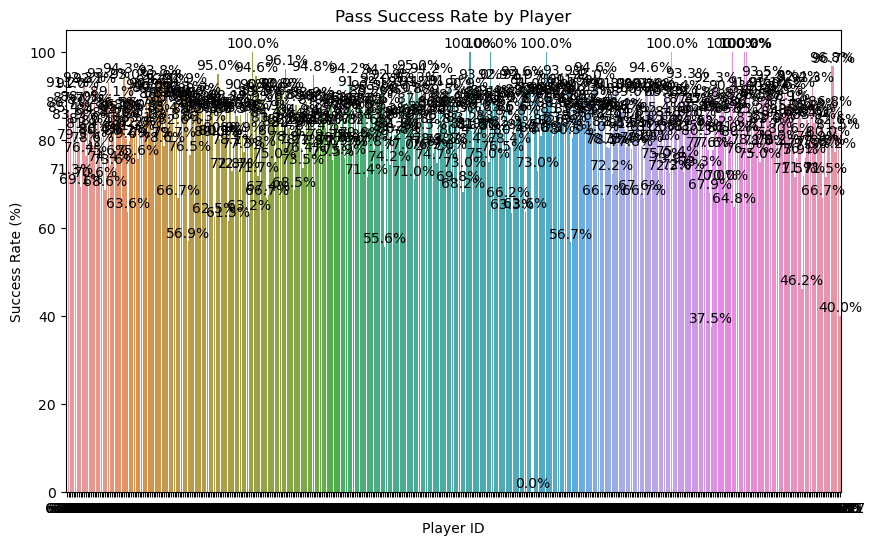

In [10]:
pass_events = train[train['type_name'] == 'Pass'].copy()

# 2. Calculate success rate per player
# Convert result_name to boolean (True if Successful, False otherwise)
pass_events['is_successful'] = pass_events['result_name'] == 'Successful'

# Group by player_id and calculate mean
pass_success_rate = pass_events.groupby('player_id')['is_successful'].mean() * 100
pass_success_rate = pass_success_rate.reset_index(name='success_rate')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='player_id', y='success_rate', data=pass_success_rate)
plt.title('Pass Success Rate by Player')
plt.ylabel('Success Rate (%)')
plt.xlabel('Player ID')
plt.ylim(0, 105) # Extend y-axis slightly

# Add text labels
for index, row in pass_success_rate.iterrows():
    plt.text(index, row.success_rate + 1, f"{row.success_rate:.1f}%", color='black', ha="center")

plt.savefig('pass_success_rate.png')

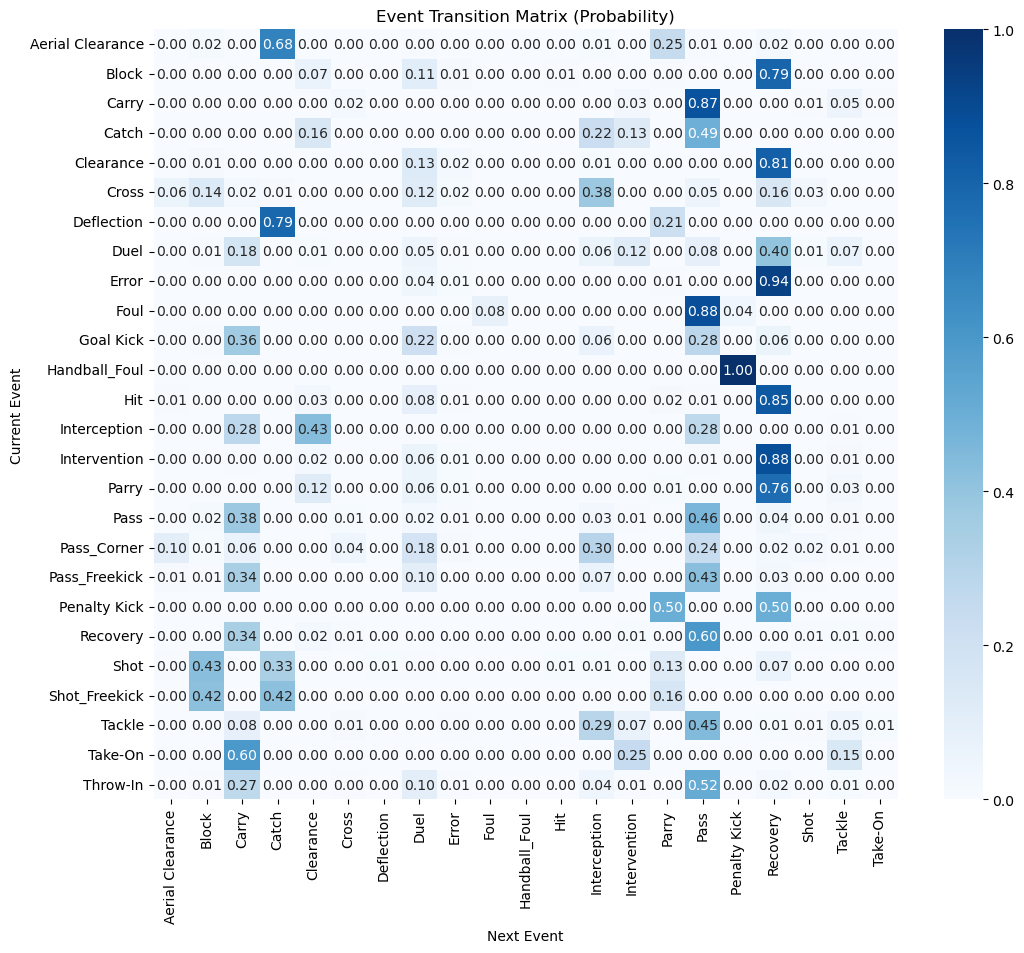

In [11]:
train['next_type_name'] = train.groupby(['game_id', 'episode_id'])['type_name'].shift(-1)

# 2. 전이 행렬 생성 (Current -> Next)
transition_matrix = pd.crosstab(train['type_name'], train['next_type_name'], normalize='index')

# 3. 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('Event Transition Matrix (Probability)')
plt.ylabel('Current Event')
plt.xlabel('Next Event')
plt.show()

In [12]:
last_events = train.groupby(['game_id', 'episode_id']).tail(1).copy()

last_events['last_x'] = last_events['end_x'].fillna(last_events['start_x'])
last_events['last_y'] = last_events['end_y'].fillna(last_events['start_y'])

# 3. 필요한 컬럼만 정리해서 확인
final_locations = last_events[['game_id', 'episode_id', 'type_name', 'last_x', 'last_y']]

print(f"총 에피소드 개수: {len(final_locations)}")
print(final_locations.head())

총 에피소드 개수: 15435
    game_id  episode_id type_name     last_x     last_y
48   126283           1      Pass  97.134030  41.793072
51   126283           3      Pass  95.927160   0.237320
58   126283           4      Pass   7.246953  66.122064
61   126283           5      Pass  76.705650   0.000000
84   126283           6      Pass  40.687185  22.635908


In [ ]:
def plot_pitch(type_name):
    pass_endings = final_locations[final_locations['type_name'] == type_name]
    plt.figure(figsize=(10, 7))
    plt.gca().set_facecolor('green')

    # 하프라인
    plt.axvline(x=50, color='white', linestyle='--', alpha=0.5)

    # KDE Heatmap
    sns.kdeplot(
        x=pass_endings['last_x'],
        y=pass_endings['last_y'],
        fill=True,
        cmap='Reds',     # 초록 배경 대비용 붉은색
        alpha=0.6,       # 투명도
        thresh=0.05      # 낮은 밀도 제거
    )

    plt.title(f'Heatmap of Sequence Ending Locations ({type_name})', fontsize=15)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    plt.grid(alpha=0.3, color='white', linestyle=':')
    plt.show()

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


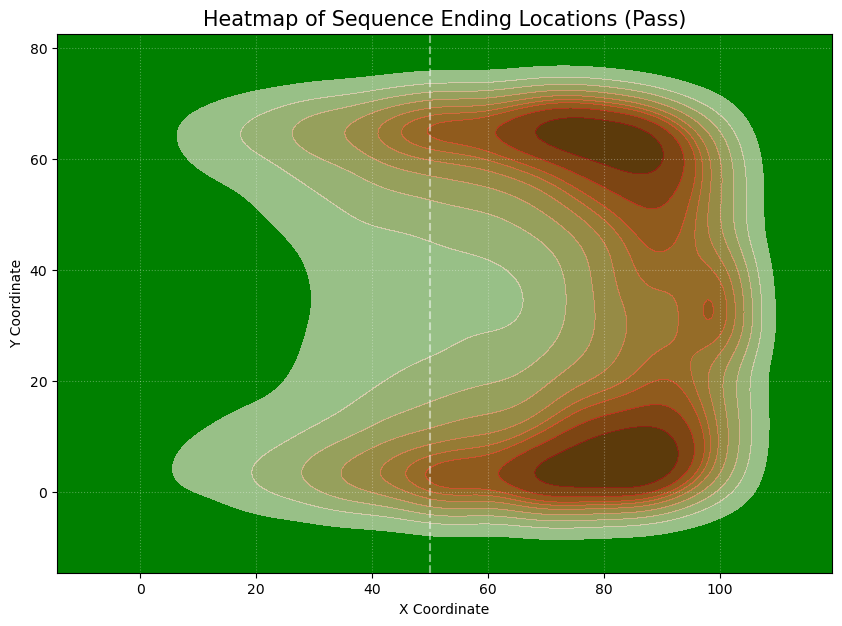

In [14]:
plot_pitch('Pass')

In [15]:
def plot_pitch_v2(type_name):
    data = train[train['type_name'] == type_name]

    plt.figure(figsize=(10, 7))
    ax = plt.gca()
    ax.set_facecolor('green')

    # 하프라인
    plt.axvline(x=50, color='white', linestyle='--', alpha=0.5)

    # START 위치 히트맵 (파란 계열)
    sns.kdeplot(
        x=data['start_x'],
        y=data['start_y'],
        fill=True,
        cmap='Purples',
        alpha=0.5,
        thresh=0.05,
        label='Start Location'
    )

    # END 위치 히트맵 (빨간 계열)
    sns.kdeplot(
        x=data['end_x'],
        y=data['end_y'],
        fill=True,
        cmap='Reds',
        alpha=0.5,
        thresh=0.05,
        label='End Location'
    )

    plt.title(f'Start vs End Location Heatmap ({type_name})', fontsize=15)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    plt.grid(alpha=0.3, color='white', linestyle=':')
    plt.legend()
    plt.show()

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

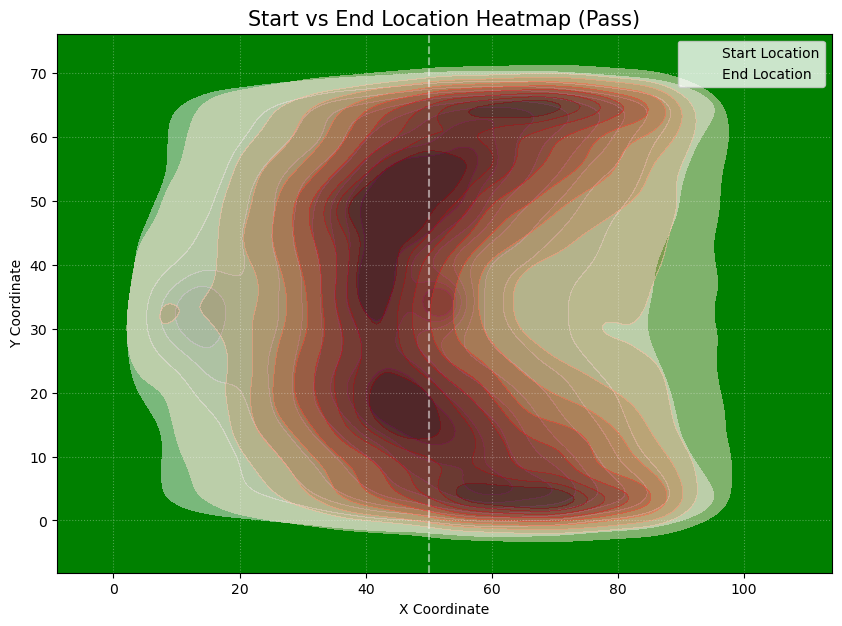

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

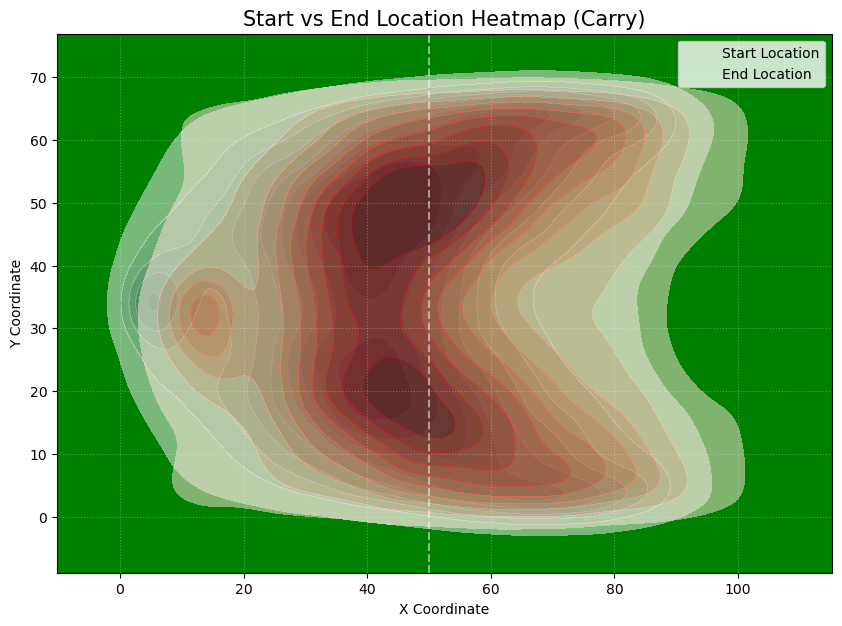

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

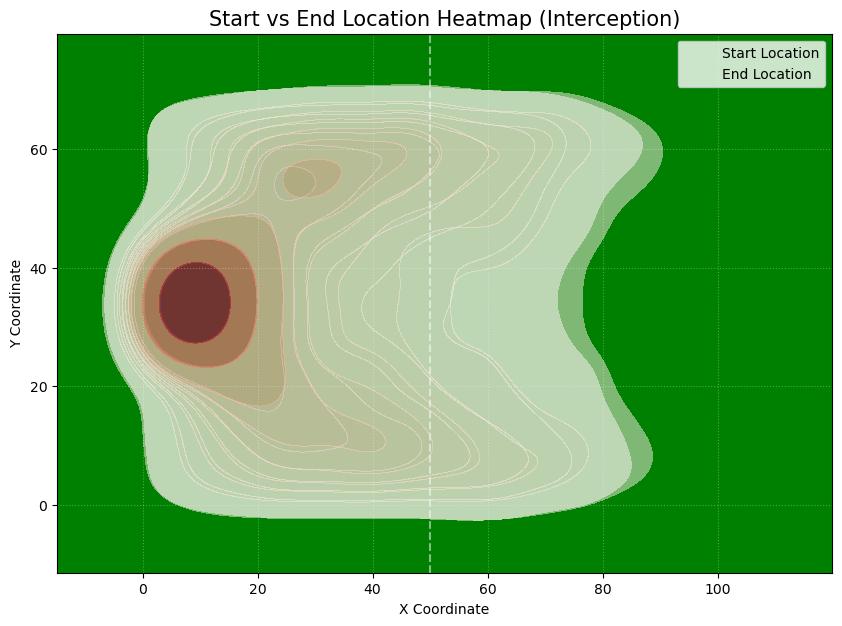

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

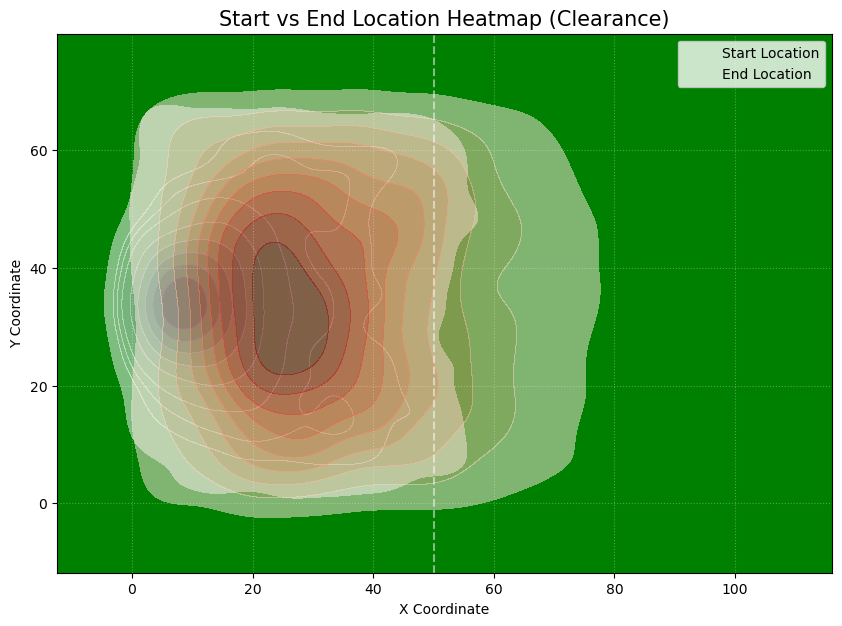

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

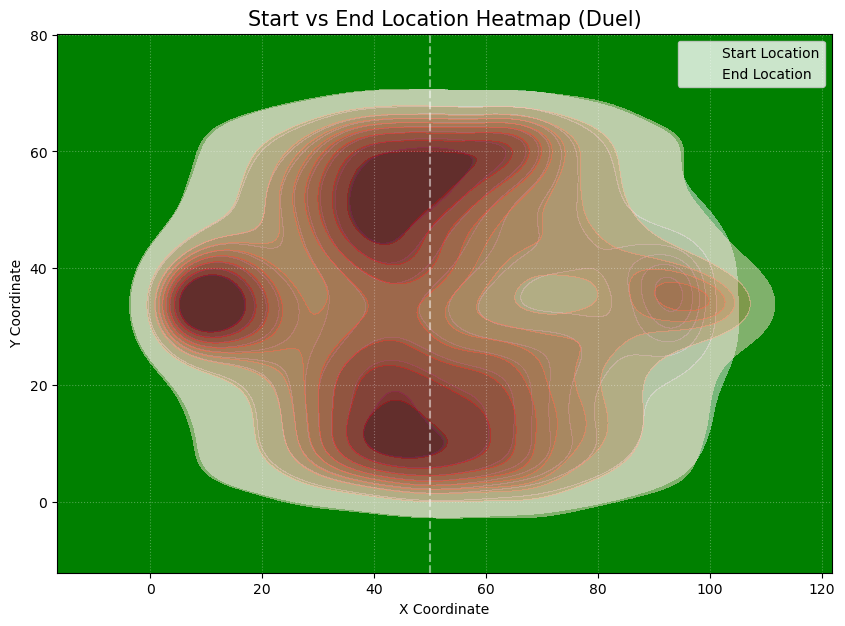

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

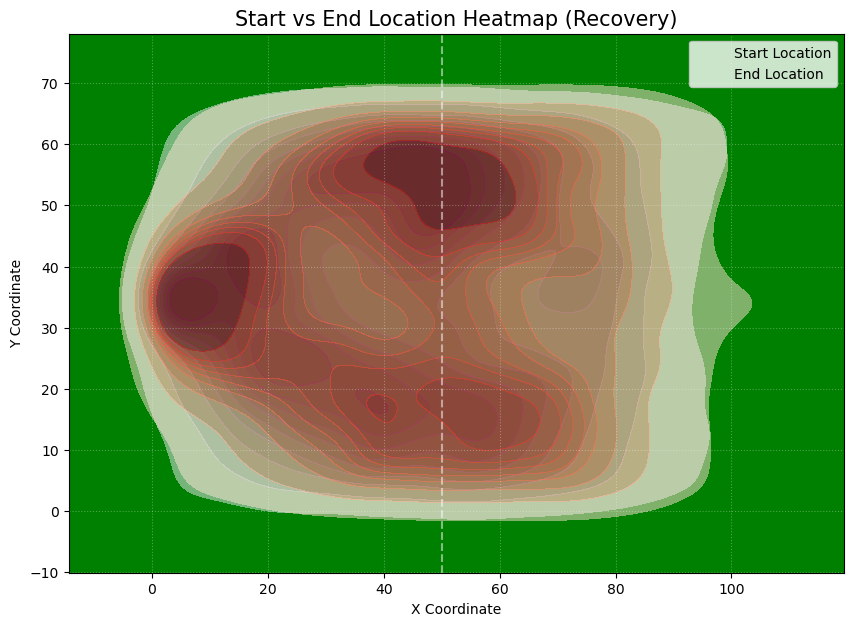

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

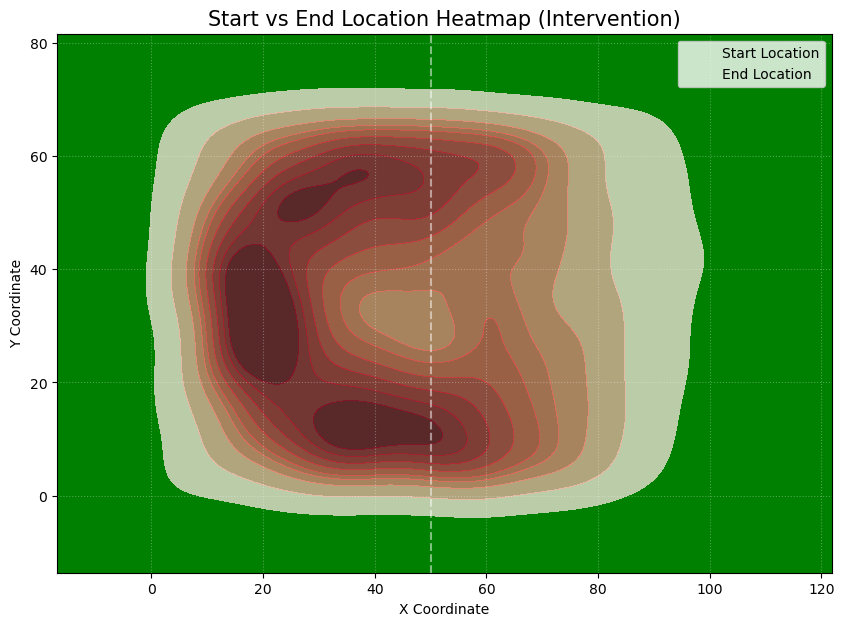

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

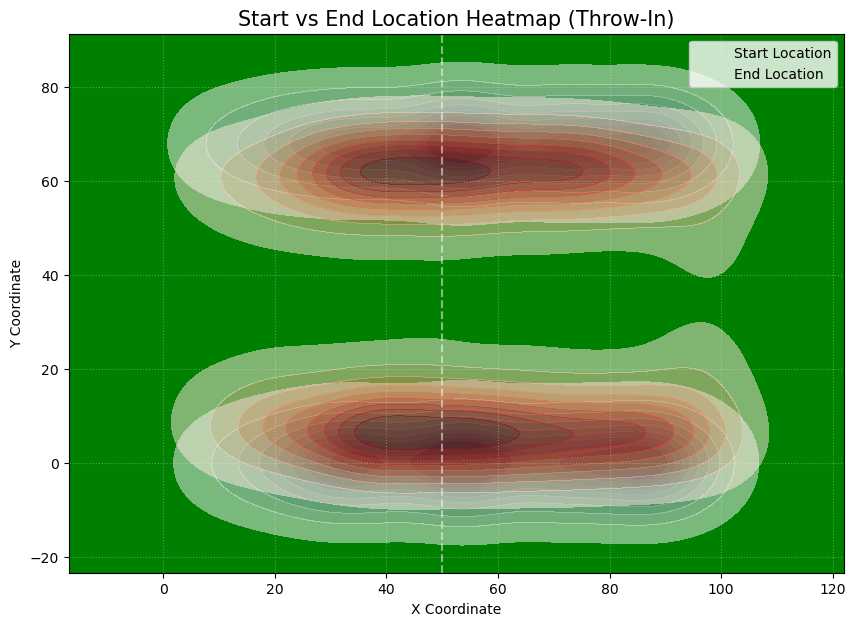

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

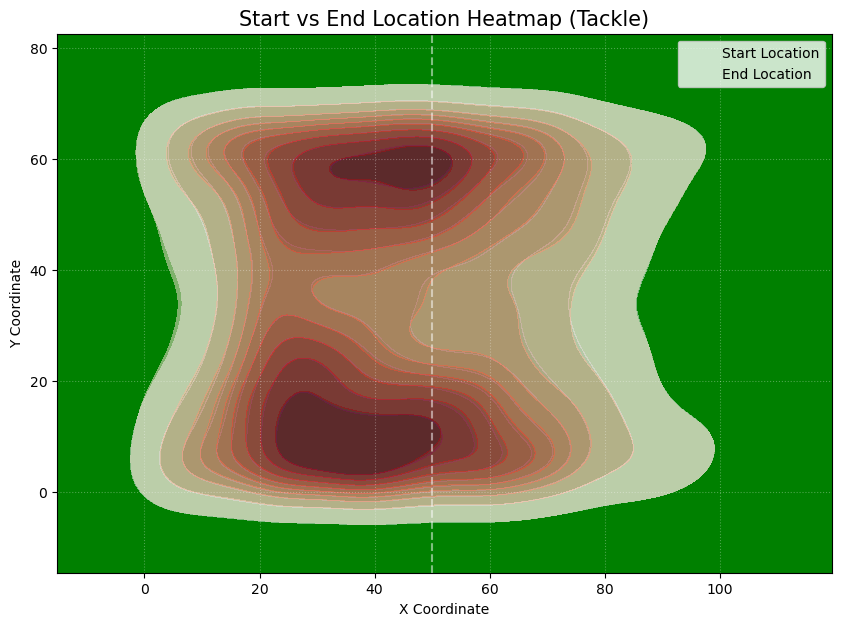

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

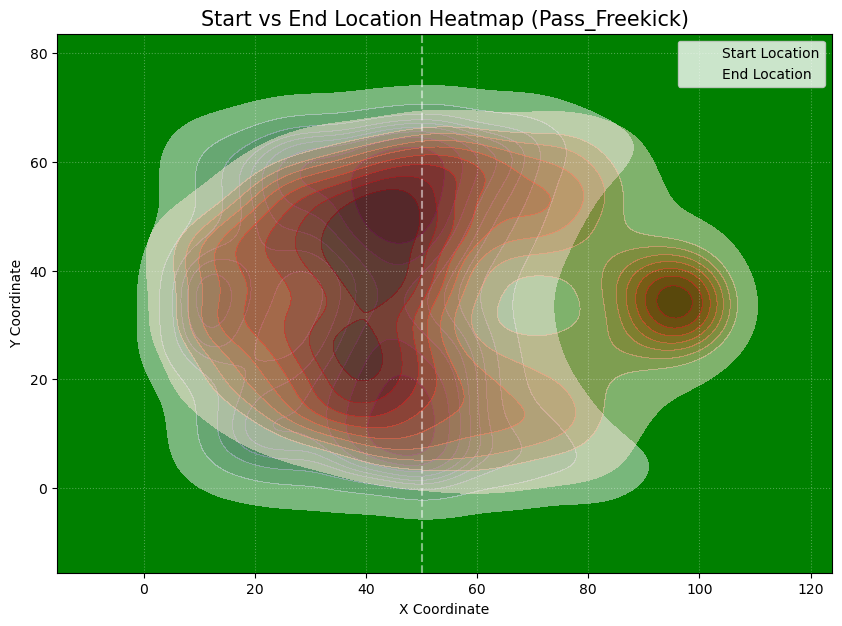

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

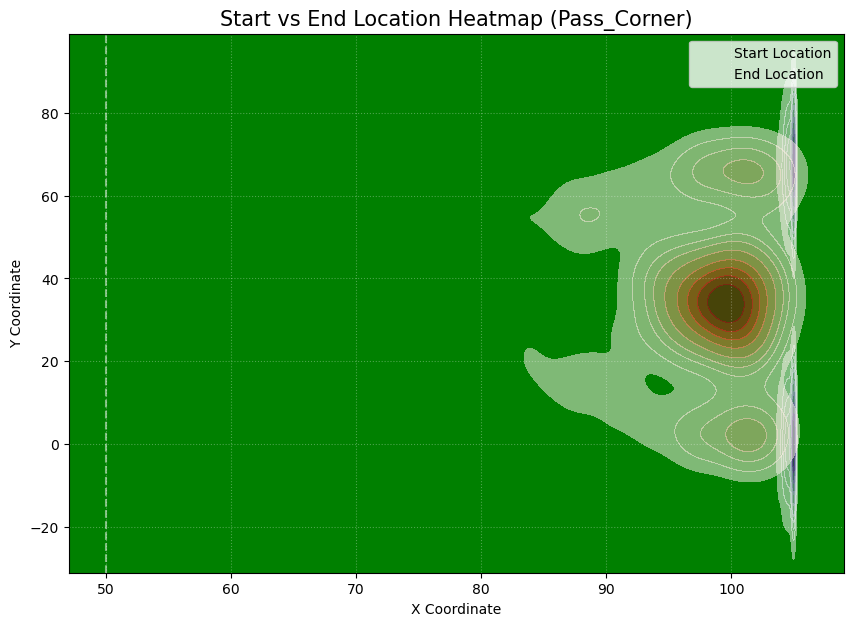

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

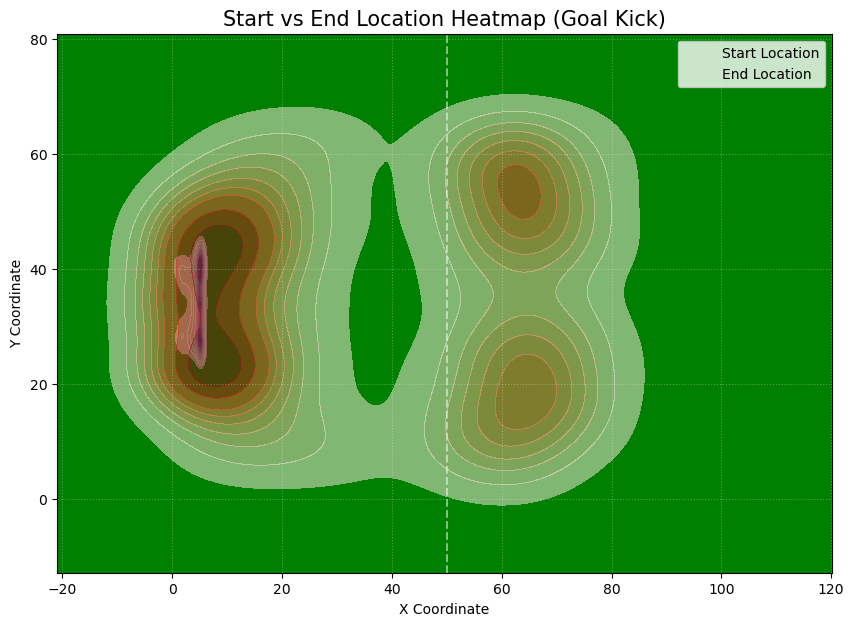

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

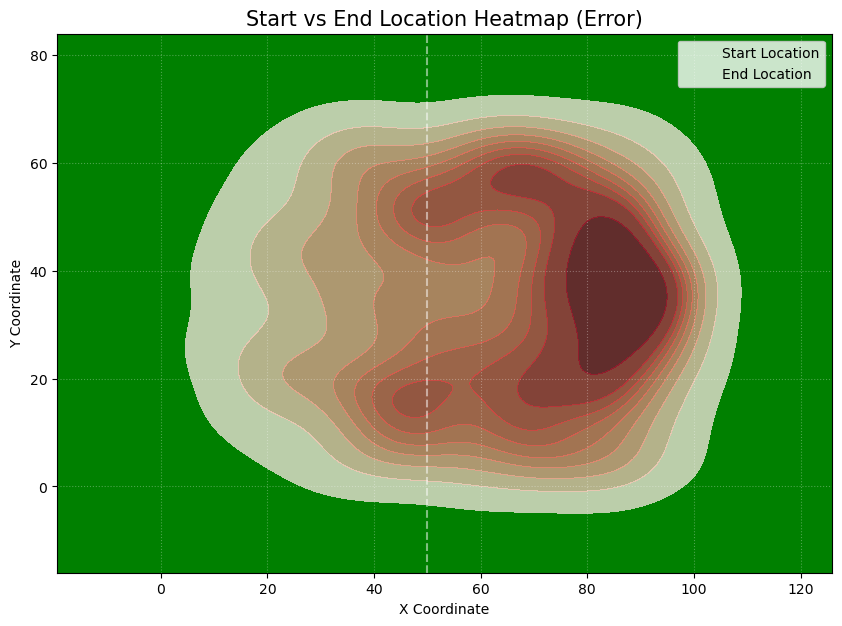

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

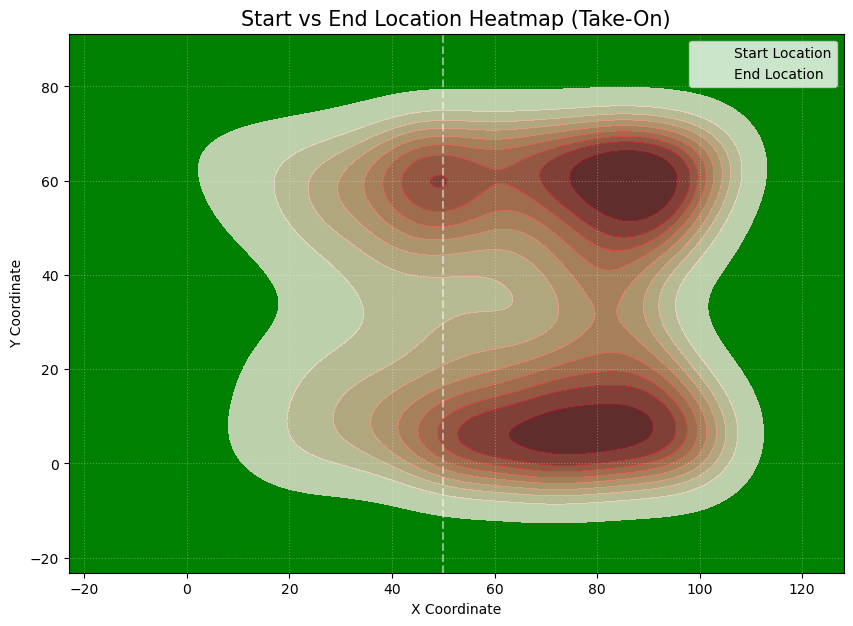

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

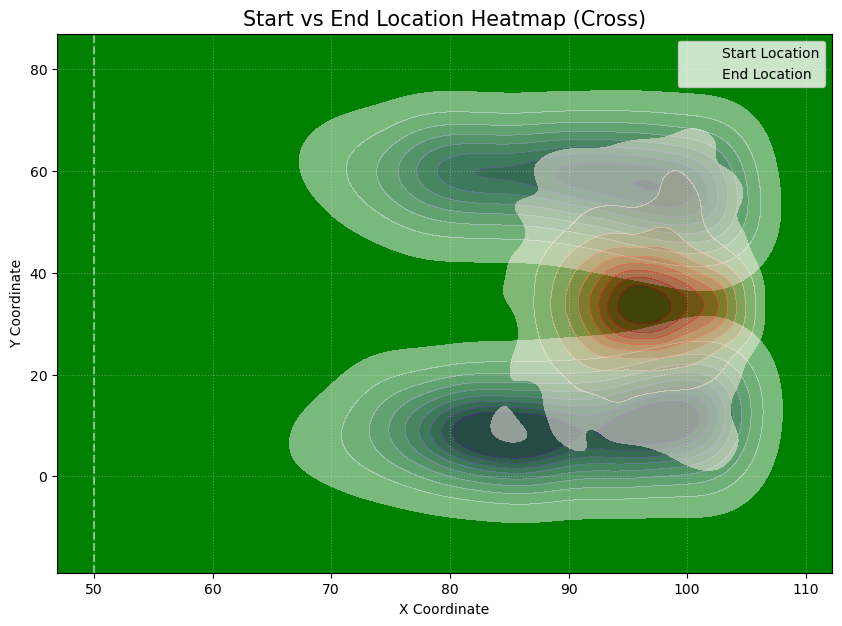

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

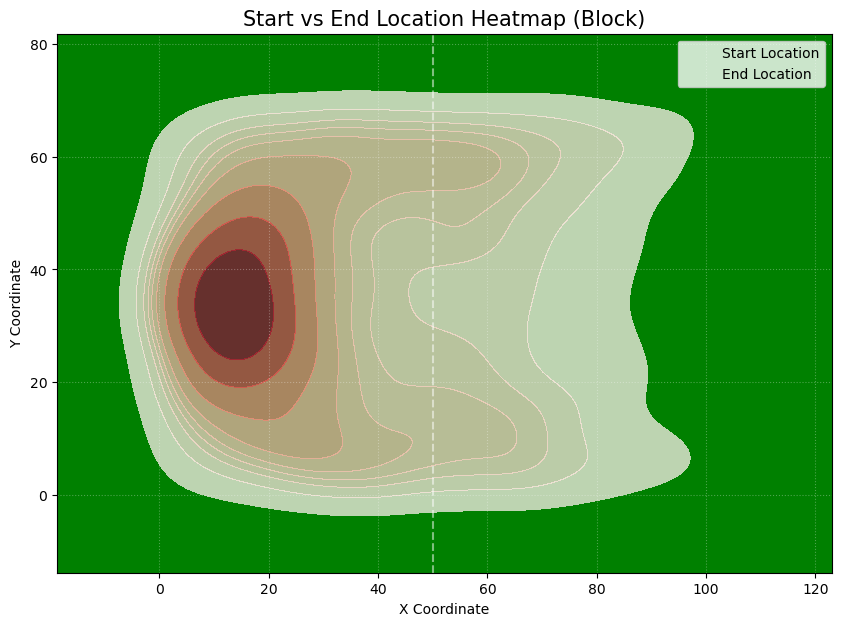

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

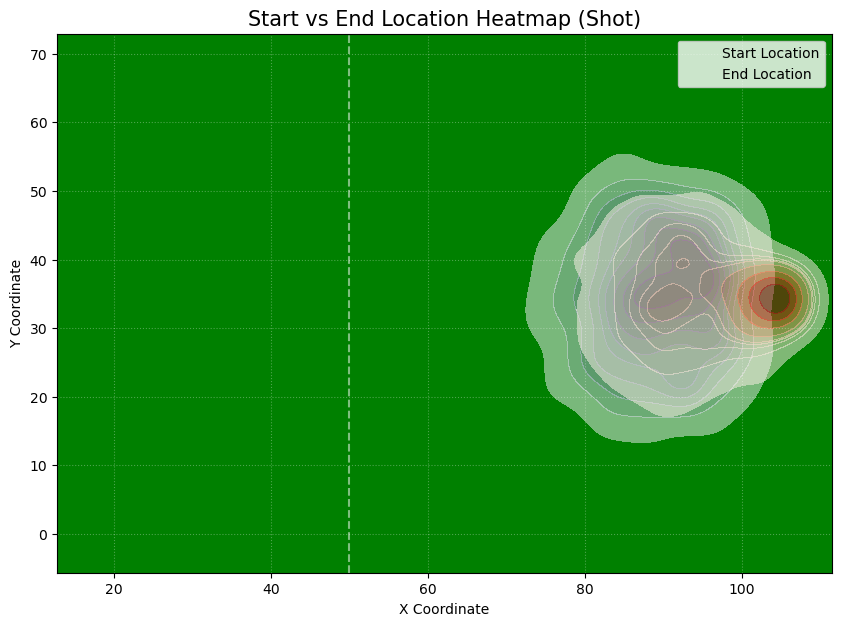

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

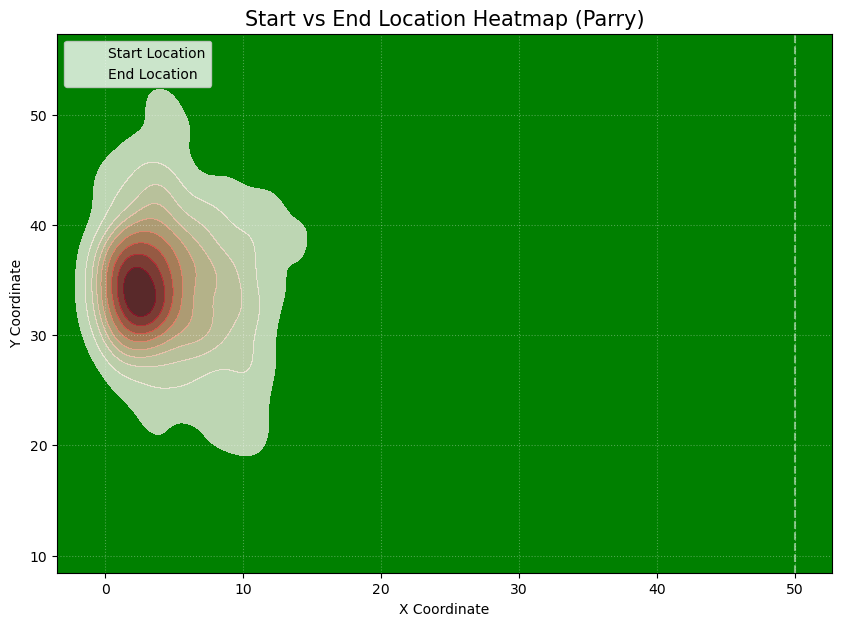

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

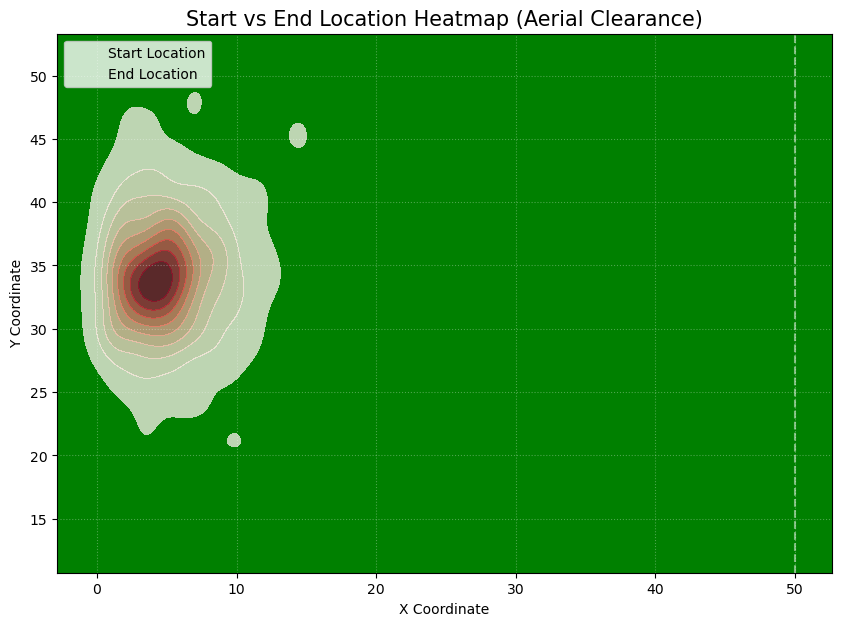

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

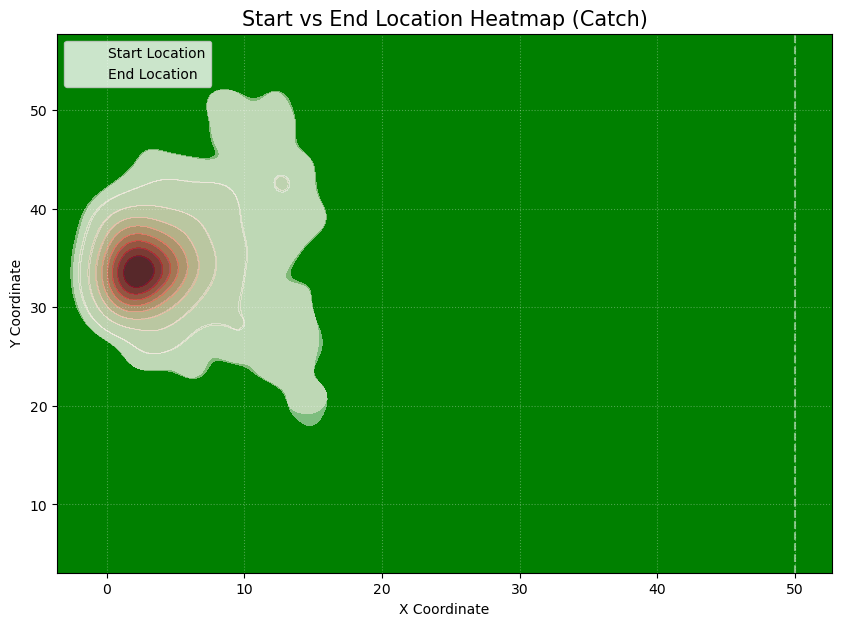

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

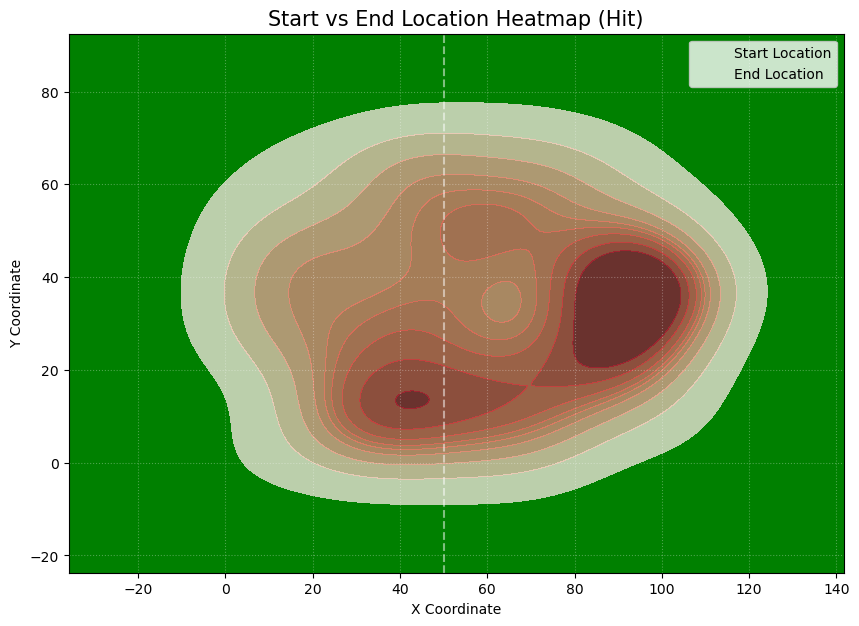

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

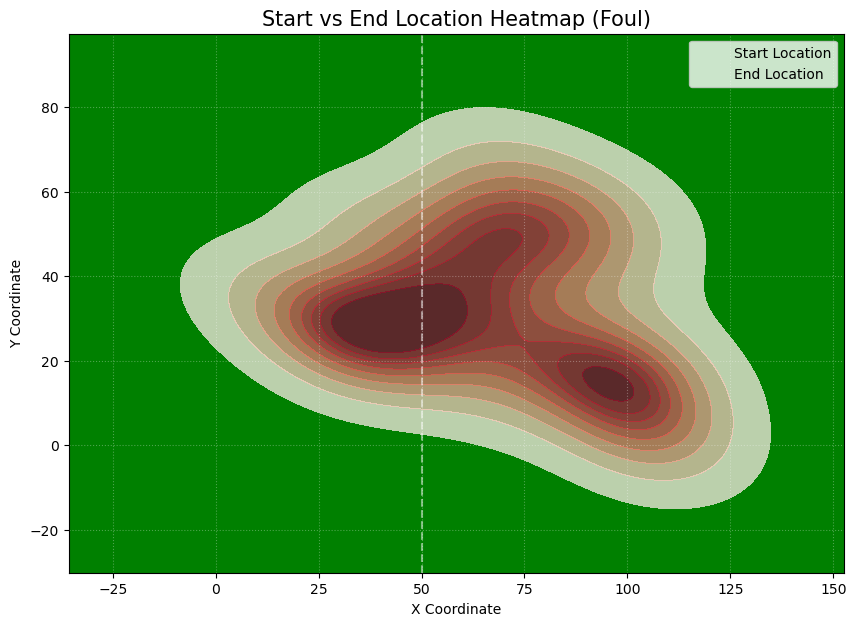

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

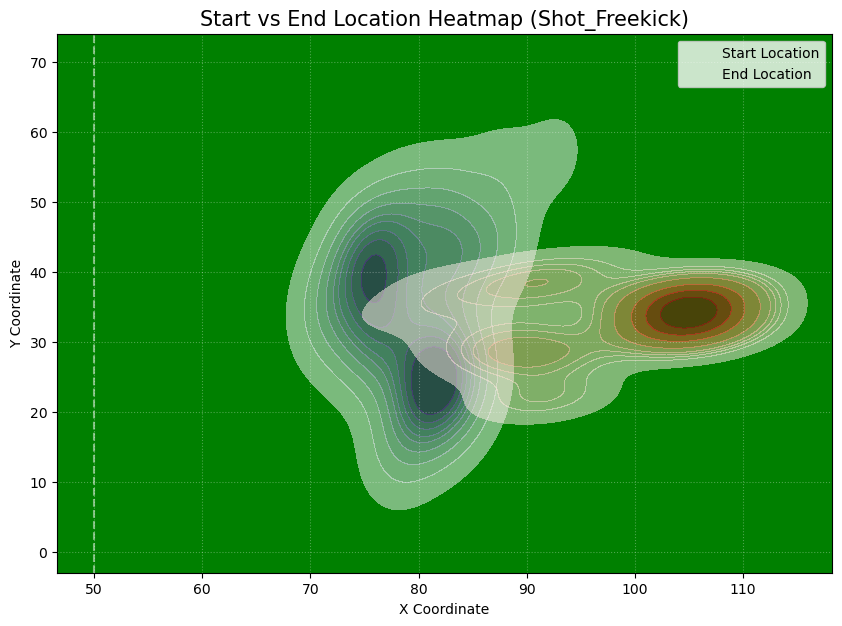

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

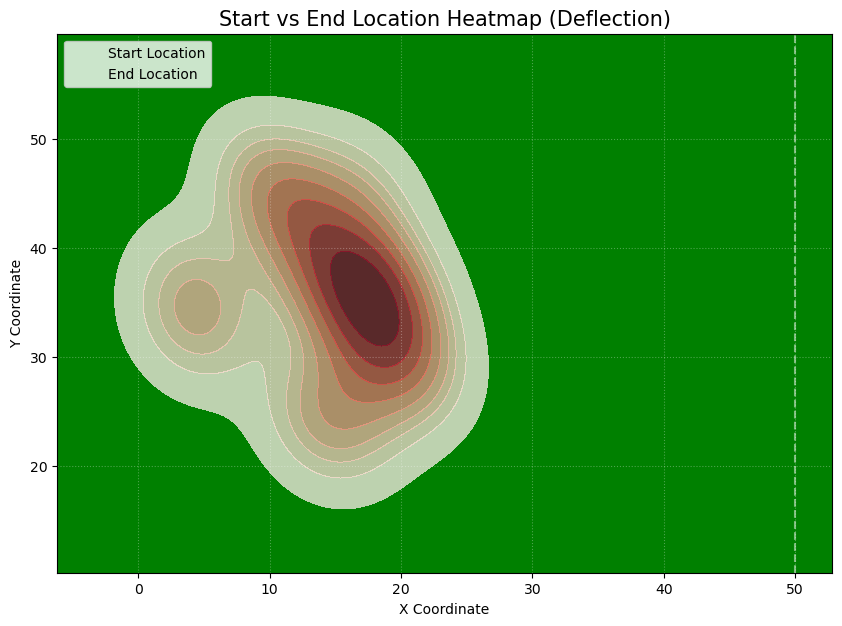

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\oem\AppData\Local\Temp\ipykernel_23228\955198798.py:12: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\

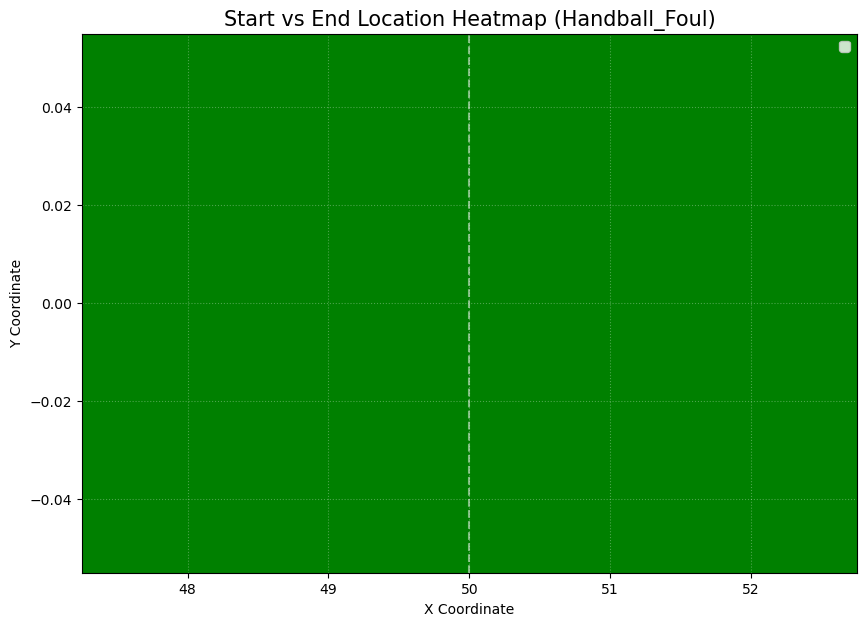

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

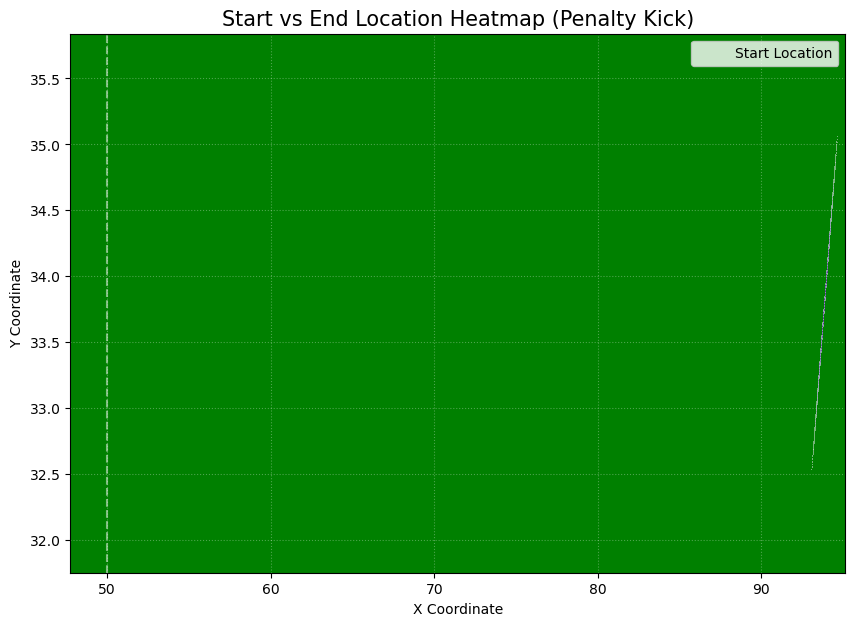

In [16]:
tp_list = train['type_name'].unique().tolist()
for tp in tp_list:
    plot_pitch_v2(tp)

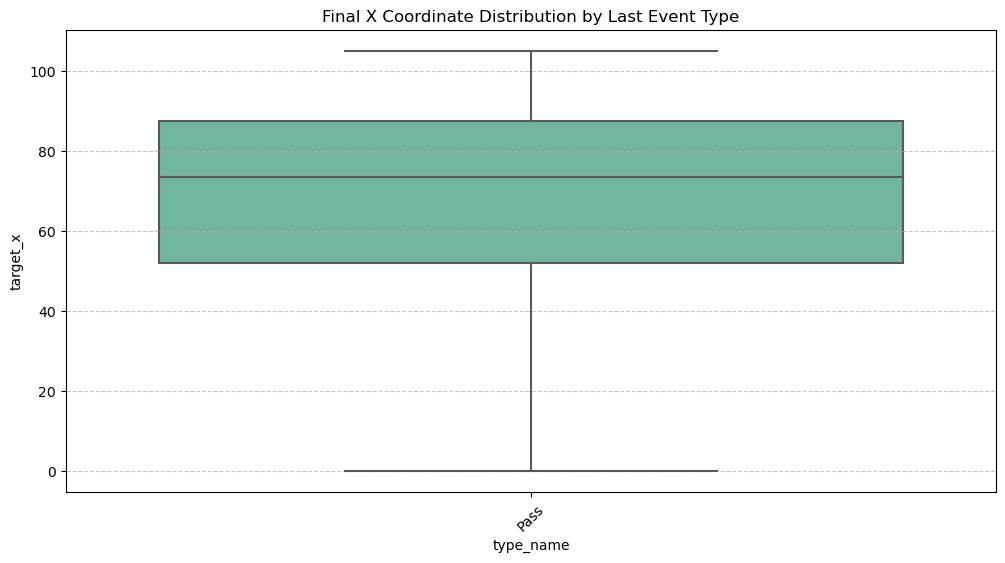

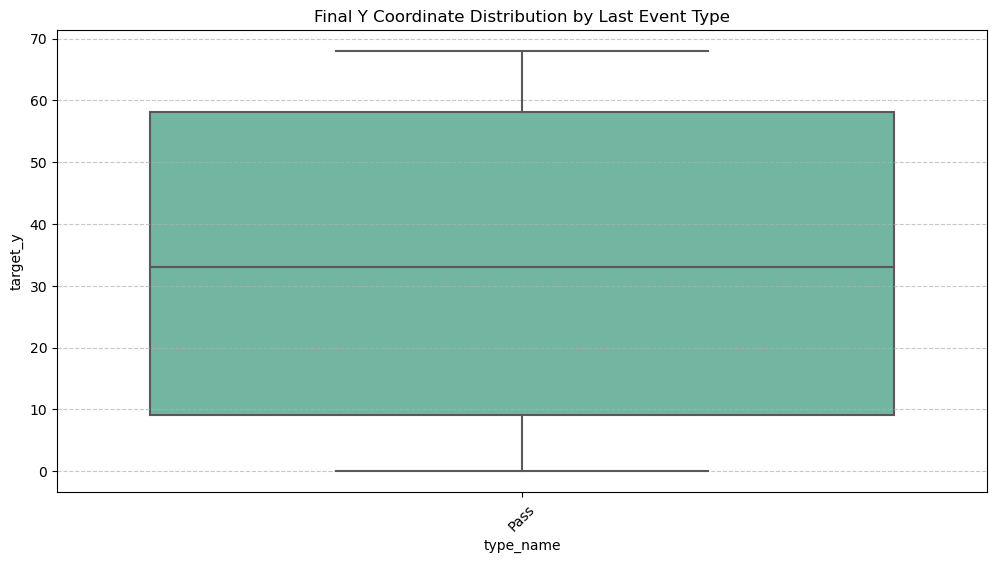

In [17]:
episode_ends = train.groupby(['game_id', 'episode_id']).tail(1).copy()

episode_ends['target_x'] = episode_ends['end_x'].fillna(episode_ends['start_x'])
episode_ends['target_y'] = episode_ends['end_y'].fillna(episode_ends['start_y'])

top_events = episode_ends['type_name'].value_counts().head(10).index
filtered_data = episode_ends[episode_ends['type_name'].isin(top_events)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='type_name', y='target_x', data=filtered_data, palette='Set2')
plt.title('Final X Coordinate Distribution by Last Event Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='type_name', y='target_y', data=filtered_data, palette='Set2')
plt.title('Final Y Coordinate Distribution by Last Event Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
def check_key_integrity(match_info, events):
    print("[Key Integrity]")
    print("Match count:", match_info['game_id'].nunique())
    print("Event game count:", events['game_id'].nunique())


    missing_games = set(match_info['game_id']) - set(events['game_id'])
    print("Missing games in events:", len(missing_games))

In [19]:
def check_missing_values(df, name):
    print(f"\n[Missing Values] {name}")
    na_ratio = df.isnull().mean().sort_values(ascending=False)
    print(na_ratio[na_ratio > 0])

In [20]:
def plot_score_distribution(match_info):
    plt.figure()
    sns.histplot(match_info['home_score'], kde=True, label='Home', stat='density')
    sns.histplot(match_info['away_score'], kde=True, label='Away', stat='density')
    plt.legend()
    plt.title("Score Distribution")
    plt.show()

In [21]:
def plot_goal_diff(match_info):
    goal_diff = match_info['home_score'] - match_info['away_score']
    plt.figure()
    sns.histplot(goal_diff, kde=True)
    plt.title("Goal Difference Distribution")
    plt.show()

In [22]:
def plot_event_type_distribution(events):
    plt.figure(figsize=(10,4))
    events['type_name'].value_counts().plot(kind='bar')
    plt.title("Event Type Distribution")
    plt.show()

In [23]:
def plot_event_success_rate(events):
    success_rate = (
    events.groupby('type_name')['result_name']
    .apply(lambda x: (x == 'Successful').mean())
    .sort_values(ascending=False)
    )
    success_rate.plot(kind='bar', figsize=(10,4))
    plt.title("Event Success Rate")
    plt.show()

In [24]:
def add_cumulative_time(events):
    events = events.copy()
    events['match_time'] = events['time_seconds'] + (events['period_id'] - 1) * 45 * 60
    return events

In [25]:
def plot_event_timeline(events):
    plt.figure()
    sns.histplot(events['match_time'] / 60, bins=30)
    plt.xlabel("Match Time (minutes)")
    plt.title("Event Density Over Time")
    plt.show()

In [26]:
def plot_event_heatmap(events, event_type):
    subset = events[events['type_name'] == event_type]
    plt.figure(figsize=(8,5))
    sns.kdeplot(
    x=subset['start_x'],
    y=subset['start_y'],
    fill=True
    )
    plt.xlim(0,105)
    plt.ylim(0,68)
    plt.title(f"{event_type} Heatmap")
    plt.show()

In [27]:
def plot_pass_direction(events):
    passes = events[events['type_name'] == 'Pass']
    delta_x = passes['end_x'] - passes['start_x']


    plt.figure()
    sns.histplot(delta_x, bins=50)
    plt.axvline(0)
    plt.title("Pass Direction Distribution (end_x - start_x)")
    plt.show()

In [28]:
def plot_episode_length(events):
    episode_len = events.groupby('game_episode').size()
    plt.figure()
    sns.histplot(episode_len, bins=30)
    plt.title("Episode Length Distribution")
    plt.xlabel("#Events per Episode")
    plt.show()

In [29]:
def plot_player_involvement(events, top_n=20):
    counts = events['player_id'].value_counts().head(top_n)
    counts.plot(kind='bar', figsize=(10,4))
    plt.title("Top Player Event Involvement")
    plt.show()

In [30]:
def detect_pass_outliers(events):
    passes = events[events['type_name'] == 'Pass'].copy()
    passes['pass_length'] = np.sqrt(
    (passes['end_x'] - passes['start_x'])**2 +
    (passes['end_y'] - passes['start_y'])**2
    )


    q1, q3 = passes['pass_length'].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = passes[passes['pass_length'] > q3 + 1.5 * iqr]


    print("Outlier passes:", len(outliers))
    return outliers

In [32]:
check_key_integrity(match_info, train)

[Key Integrity]
Match count: 228
Event game count: 198
Missing games in events: 30


In [34]:
check_missing_values(train, "Train")


[Missing Values] Train
result_name       0.393176
next_type_name    0.043269
dtype: float64


c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


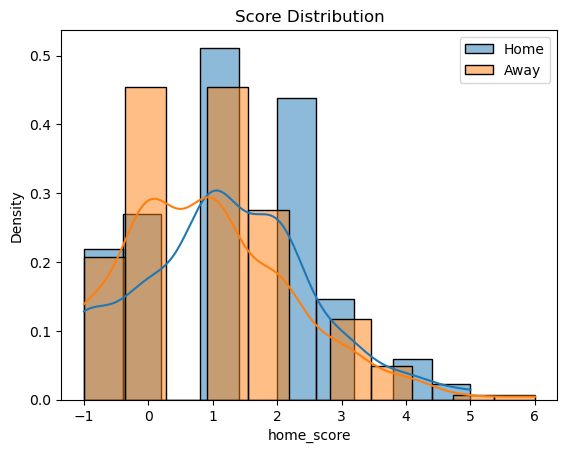

In [35]:
plot_score_distribution(match_info)

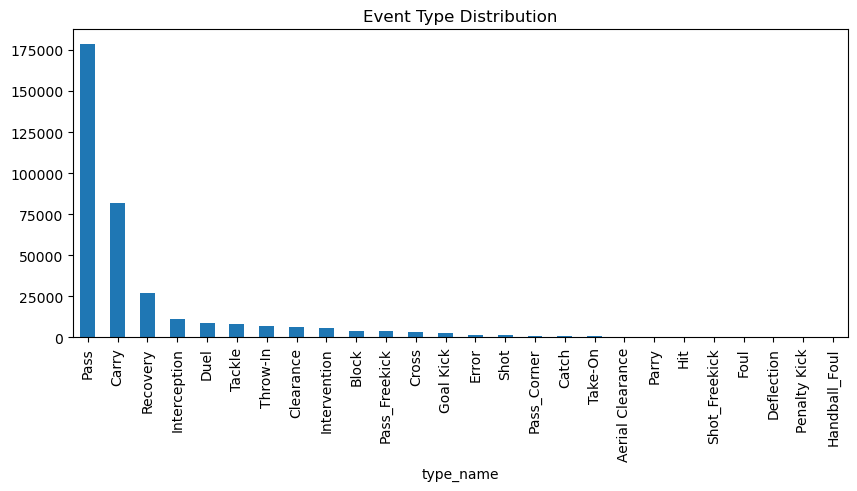

In [36]:
plot_event_type_distribution(train)

In [37]:
train_re = add_cumulative_time(train)

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


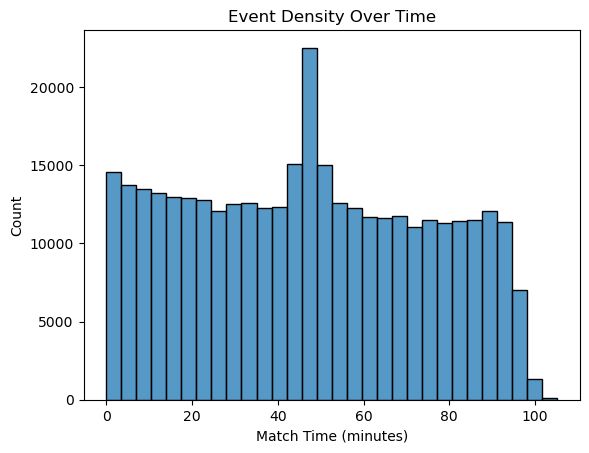

In [38]:
plot_event_timeline(train_re)

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


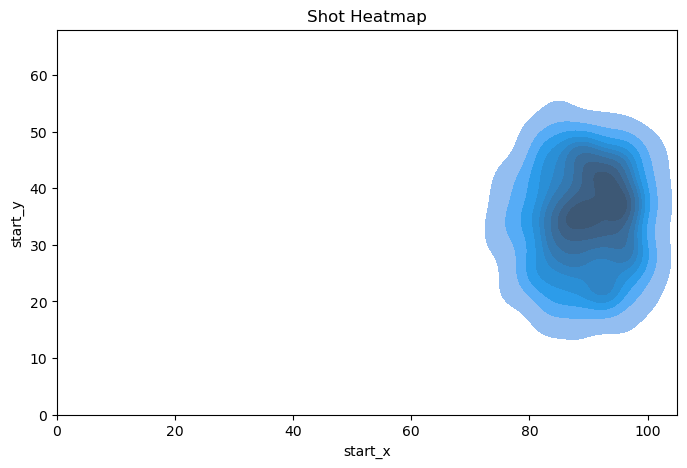

In [39]:
plot_event_heatmap(train_re, "Shot")

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


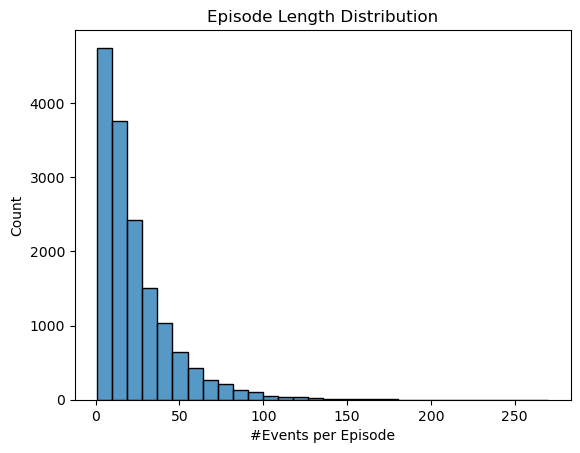

In [40]:
plot_episode_length(train_re)